##DEVELOP AN IMAGE CLASSIFIER THAT AUTOMATICALLY DISTINGUISH BETWEEN RECYCLABLE AND ORGANIC WASTE ITEMS.
### Approach:
1. Build a custom CNN model
2. Transfer learning RESNET18
3. Compare the performance and choose the best model for deployment

Dataset : Kaggle - waste classification data (https://www.kaggle.com/datasets/techsash/waste-classification-data)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import copy
import time
from PIL import Image
import torch
import torchvision.transforms as transforms
from collections import Counter
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models



from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


In [3]:
data_dir = "/content/drive/My Drive/DATASET/DATASET"
train_dir = os.path.join(data_dir, "TRAIN")
test_dir = os.path.join(data_dir, "TEST")

In [4]:
print("Contents of training directory:")
print(os.listdir(train_dir))

print("\nContents of testing directory:")
print(os.listdir(test_dir))

Contents of training directory:
['O', 'R']

Contents of testing directory:
['O', 'R']


In [5]:
# Define transformations for the images
# resize, center crop, and normalize the images
data_transforms = {
    'TRAIN': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet normalization
    ]),
    'TEST': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create datasets
image_datasets = {
    'TRAIN': datasets.ImageFolder(train_dir, data_transforms['TRAIN']),
    'TEST': datasets.ImageFolder(test_dir, data_transforms['TEST'])
}

# Create dataloaders
dataloaders = {
    'TRAIN': DataLoader(image_datasets['TRAIN'], batch_size=128, shuffle=True, num_workers=2),
    'TEST': DataLoader(image_datasets['TEST'], batch_size=128, shuffle=False, num_workers=2)
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['TRAIN', 'TEST']}
class_names = image_datasets['TRAIN'].classes

print("Dataset sizes:", dataset_sizes)
print("Class names:", class_names)

Dataset sizes: {'TRAIN': 22564, 'TEST': 2513}
Class names: ['O', 'R']


TRAIN distribution: Counter({0: 12565, 1: 9999})
TEST distribution: Counter({0: 1401, 1: 1112})


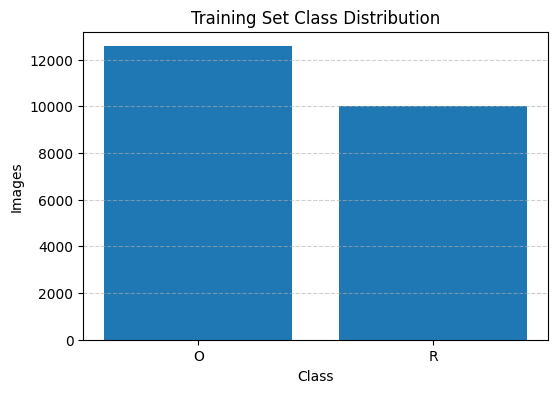

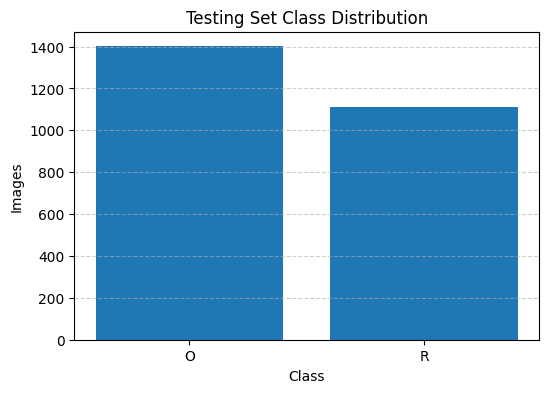

In [7]:


train_labels = [label for _, label in image_datasets['TRAIN'].samples]
test_labels  = [label for _, label in image_datasets['TEST'].samples]

train_counts = Counter(train_labels)
test_counts = Counter(test_labels)

print("TRAIN distribution:", train_counts)
print("TEST distribution:", test_counts)

# --- Plot
def plot_distribution(counts, title):
    labels = [class_names[i] for i in counts.keys()]
    values = list(counts.values())

    plt.figure(figsize=(6,4))
    plt.bar(labels, values)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Images")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()

plot_distribution(train_counts, "Training Set Class Distribution")
plot_distribution(test_counts, "Testing Set Class Distribution")


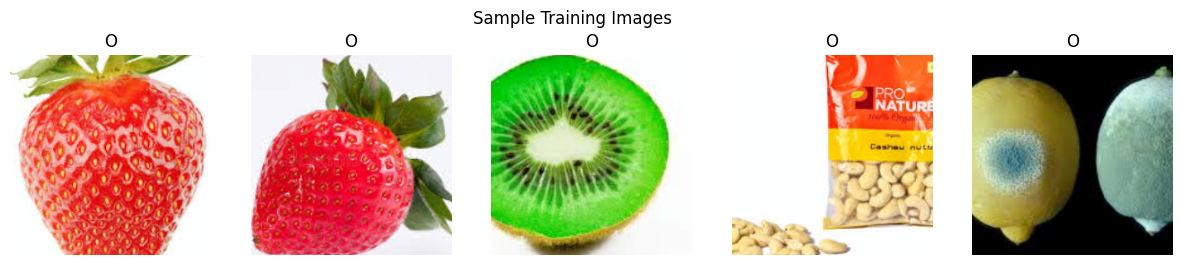

In [8]:
def show_sample_images(dataset, title):
    fig, axes = plt.subplots(1, 5, figsize=(15,3))
    fig.suptitle(title)

    for i in range(5):
        img, label = dataset[i]
        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img * np.array([0.229, 0.224, 0.225]) +
                      np.array([0.485, 0.456, 0.406]), 0, 1)
        axes[i].imshow(img)
        axes[i].set_title(class_names[label])
        axes[i].axis("off")

    plt.show()

show_sample_images(image_datasets['TRAIN'], "Sample Training Images")


In [9]:
img, _ = image_datasets['TRAIN'][0]
print("Image shape:", img.shape)   # Expected: (3, 224, 224)


Image shape: torch.Size([3, 224, 224])


### Modelling
1. Custom CNN model

*   3 convolution and max pooling layers
*   ReLU acttivation as the activation function of the network




In [10]:
# Define the device to use
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(64 * 28 * 28, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = x.view(-1, 64 * 28 * 28) # Flatten the output for the fully connected layer
        x = self.fc(x)
        return x

model = SimpleCNN(num_classes=len(class_names))

# Move the model to the selected device
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Using device: cuda:0


In [ ]:

def train_cnn(model, dataloaders, criterion, optimizer, device, num_epochs=10, checkpoint_path="best_model.pth"):
    """
    Train and evaluate a CNN model on an image classification dataset.

    Args:
        model: torch.nn.Module - the CNN model
        dataloaders: dict - {'TRAIN': DataLoader, 'TEST': DataLoader}
        criterion: loss function ( CrossEntropyLoss)
        optimizer: optimizer ( Adam)
        device: 'cuda' or 'cpu'
        num_epochs: number of training epochs
        checkpoint_path: optional path to save best model weights

    Returns:
        model: trained model with best weights
        history: dict containing train/test loss & accuracy
    """

    start_time = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 40)

        # Each epoch has a training and validation phase
        for phase in ['TRAIN', 'TEST']:
            if phase == 'TRAIN':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in tqdm(dataloaders[phase], desc=f"{phase}"):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'TRAIN'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backpropagation + optimization
                    if phase == 'TRAIN':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Compute epoch metrics
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            if phase == 'TRAIN':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['test_loss'].append(epoch_loss)
                history['test_acc'].append(epoch_acc.item())

            print(f"{phase} Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")

            # Deep copy the model if it has the best accuracy so far
            if phase == 'TEST' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, checkpoint_path)
                print(f" Best model updated and saved to '{checkpoint_path}'")

        print()

    # Time summary
    total_time = time.time() - start_time
    print(f"Training complete in {total_time//60:.0f}m {total_time%60:.0f}s")
    print(f"Best validation accuracy: {best_acc:.4f}")

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history


In [ ]:
model, history = train_cnn(
    model=model,
    dataloaders=dataloaders,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=10,
    checkpoint_path="best_cnn_model.pth"
)


In [ ]:
# Load the best saved model
model.load_state_dict(torch.load("best_cnn_model.pth"))
model.to(device)


In [11]:
def evaluate_model(model, dataloader, criterion, device, class_names):

    """
        validation of the model on test dataset.

        Args:
            model: torch.nn.Module - the CNN model
            dataloaders: dict - {'TRAIN': DataLoader, 'TEST': DataLoader}
            criterion: loss function ( CrossEntropyLoss)
            device: 'cuda' or 'cpu'
            class_names: list of class names

        Returns:
            average loss and accuracy of the evaluated validation set
        """
    model.eval()
    all_preds = []
    all_labels = []
    test_loss = 0.0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = test_loss / len(dataloader.dataset)
    acc = np.mean(np.array(all_preds) == np.array(all_labels))

    print(f"\n Test Loss: {avg_loss:.4f}")
    print(f" Test Accuracy: {acc:.4f}\n")

    print("Detailed Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    return avg_loss, acc


In [ ]:
model = SimpleCNN(num_classes=len(class_names))
model.load_state_dict(torch.load("/content/drive/MyDrive/simplecnn_trained.pth", map_location=device))
model.to(device)
model.eval()

print("✅ Model loaded successfully from Google Drive!")


✅ Model loaded successfully from Google Drive!


##Evaluation  of the model with confusion matrix

Evaluating: 100%|██████████| 20/20 [10:36<00:00, 31.80s/it]



 Test Loss: 0.3134
 Test Accuracy: 0.8938

Detailed Classification Report:
              precision    recall  f1-score   support

           O       0.87      0.95      0.91      1401
           R       0.93      0.82      0.87      1112

    accuracy                           0.89      2513
   macro avg       0.90      0.89      0.89      2513
weighted avg       0.90      0.89      0.89      2513



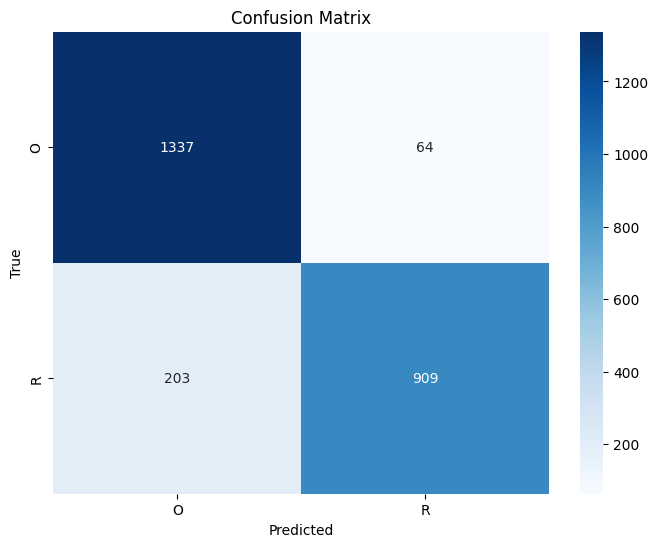

In [ ]:
test_loss, test_acc = evaluate_model(
    model=model,
    dataloader=dataloaders['TEST'],
    criterion=criterion,
    device=device,
    class_names=class_names
)


Testing the model with one image

In [ ]:

# Path to the image
image_path = "/content/drive/MyDrive/DATASET/TEST/R/R_10001.jpg"

# Apply same transforms used in training
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load and transform
image = Image.open(image_path).convert("RGB")
img_tensor = transform(image).unsqueeze(0).to(device)

# Predict
model.eval()
with torch.no_grad():
    outputs = model(img_tensor)
    _, predicted = torch.max(outputs, 1)
    predicted_class = class_names[predicted.item()]

print(f"Predicted Class: {predicted_class}")


Predicted Class: R


2. Fine tuning transfer modelling (ResNet18)


In [12]:

def build_finetune_resnet18(num_classes):
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    # Freeze all layers first
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last two layers (layer4 and fc)
    for param in model.layer4.parameters():
        param.requires_grad = True

    # Replace final FC layer with the number of classes
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    return model


# Build model
model_ft = build_finetune_resnet18(num_classes=len(class_names))
model_ft = model_ft.to(device)

# Set different LR for pretrained and new layers
optimizer_ft = torch.optim.Adam([
    {"params": model_ft.layer4.parameters(), "lr": 1e-4},
    {"params": model_ft.fc.parameters(), "lr": 1e-3},
])

criterion = nn.CrossEntropyLoss()

print("✅ ResNet18 model created for fine-tuning")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 185MB/s]


✅ ResNet18 model created for fine-tuning


In [13]:
model_ft, history_ft = train_cnn(
    model=model_ft,
    dataloaders=dataloaders,
    criterion=criterion,
    optimizer=optimizer_ft,
    device=device,
    num_epochs=10,
    checkpoint_path="resnet18_finetuned.pth"
)


NameError: name 'train_cnn' is not defined

In [ ]:
model_ft = build_finetune_resnet18(num_classes=len(class_names))
model_ft.load_state_dict(torch.load("/content/drive/MyDrive/resnet18_finetuned.pth", map_location=device))
model_ft.to(device)
model_ft.eval()

print(" Model loaded successfully from Google Drive!")


 Model loaded successfully from Google Drive!


Evaluation of the fine tuned model

Evaluating: 100%|██████████| 20/20 [04:10<00:00, 12.53s/it]



 Test Loss: 0.6667
 Test Accuracy: 0.6140

Detailed Classification Report:
              precision    recall  f1-score   support

           O       0.60      0.89      0.72      1401
           R       0.66      0.26      0.38      1112

    accuracy                           0.61      2513
   macro avg       0.63      0.58      0.55      2513
weighted avg       0.63      0.61      0.57      2513



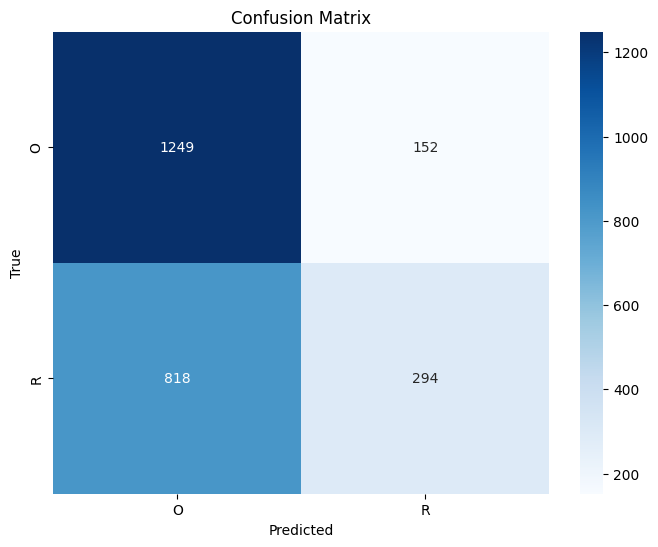

In [14]:
test_loss_ft, test_acc_ft = evaluate_model(
    model=model_ft,
    dataloader=dataloaders['TEST'],
    criterion=criterion,
    device=device,
    class_names=class_names
)


In [15]:
def gradcam_single_image(model, img_tensor, target_layer, device=device, class_idx=None):
    """
    img_tensor: torch.Tensor of shape (3, H, W), normalized
    target_layer: e.g. model.layer4[-1].conv2
    class_idx: optional int, if None uses predicted class
    """
    model.eval()
    activations = []
    gradients = []

    def forward_hook(module, inp, out):
        activations.append(out)

    def backward_hook(module, grad_in, grad_out):
        # grad_out[0] has shape (N, C, H, W)
        gradients.append(grad_out[0])

    # register hooks
    h1 = target_layer.register_forward_hook(forward_hook)
    h2 = target_layer.register_full_backward_hook(backward_hook)

    # add batch dimension and move to device
    img_tensor = img_tensor.unsqueeze(0).to(device)  # (1,3,H,W)

    # forward pass
    outputs = model(img_tensor)  # (1, num_classes)

    if class_idx is None:
        class_idx = outputs.argmax(dim=1).item()

    # scalar score for the target class
    score = outputs[:, class_idx]

    # backward pass
    model.zero_grad()
    score.backward()

    # get saved activations and gradients
    acts = activations[-1]          # (1, C, H, W)
    grads = gradients[-1]           # (1, C, H, W)
    grads = grads[0]                # (C, H, W)
    acts = acts[0]                  # (C, H, W)

    # global average pooling over H, W for weights
    weights = grads.mean(dim=(1, 2))  # (C,)

    # weighted sum of activations
    cam = torch.zeros(acts.shape[1:], dtype=torch.float32, device=device)  # (H, W)
    for w, a in zip(weights, acts):
        cam += w * a

    cam = F.relu(cam)

    # normalize 0–1
    cam -= cam.min()
    cam /= (cam.max() + 1e-8)

    # clean up hooks
    h1.remove()
    h2.remove()

    return cam.detach().cpu().numpy(), class_idx

In [16]:
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD  = np.array([0.229, 0.224, 0.225])

def unnormalize(img_tensor):
    """img_tensor: (3,H,W) tensor -> (H,W,3) numpy in [0,1]"""
    img = img_tensor.detach().cpu().permute(1, 2, 0).numpy()
    img = img * IMAGENET_STD + IMAGENET_MEAN
    img = np.clip(img, 0, 1)
    return img

def show_gradcam_side_by_side(img_tensor, cam, title=None):
    """
    img_tensor: normalized (3,H,W)
    cam: numpy (H,W) from gradcam_single_image
    """
    img = unnormalize(img_tensor)

    # resize cam to image size if needed
    if cam.shape != img.shape[:2]:
        from skimage.transform import resize
        cam_resized = resize(cam, img.shape[:2], preserve_range=True)
    else:
        cam_resized = cam

    heatmap = plt.cm.jet(cam_resized)[..., :3]  # drop alpha
    overlay = 0.4 * heatmap + 0.6 * img
    overlay = np.clip(overlay, 0, 1)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(img)
    axes[0].set_title("Original")
    axes[0].axis("off")

    axes[1].imshow(cam_resized, cmap="jet")
    axes[1].set_title("Grad-CAM")
    axes[1].axis("off")

    axes[2].imshow(overlay)
    axes[2].set_title("Overlay")
    axes[2].axis("off")

    if title:
        fig.suptitle(title)
    plt.tight_layout()
    plt.show()


True label : O
Pred label : O


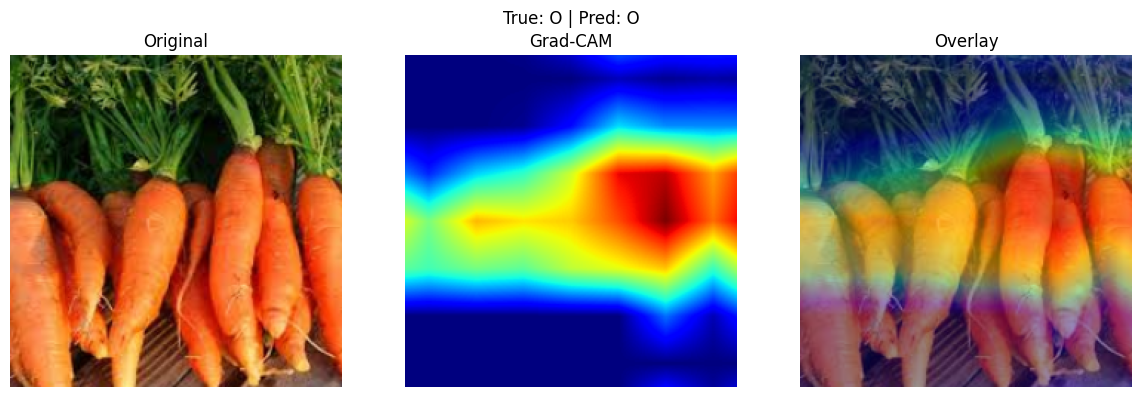

In [20]:

# pick an index from TEST set
idx = 0
img_tensor, true_label = image_datasets['TEST'][idx]

# target conv layer in ResNet (layer4 conv filters)
target_layer = model_ft.layer4[-1].conv2

# compute Grad-CAM
cam, pred_idx = gradcam_single_image(
    model_ft,
    img_tensor,
    target_layer=target_layer,
    device=device,
    class_idx=None   # None => uses predicted class
)

print("True label :", class_names[true_label])
print("Pred label :", class_names[pred_idx])

# visualize original + Grad-CAM + overlay
title = f"True: {class_names[true_label]} | Pred: {class_names[pred_idx]}"
show_gradcam_side_by_side(img_tensor, cam, title=title)
